In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#read in KSCL arrivals data
df = pd.read_csv("KSLC_arrivals_tidy.csv")

In [3]:
#drop the old index
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
#create separate dfs with the numeric and categorical variables and scale the numeric df
num_cols = ['scheduled_elapsed', 'distance', 'year','day_of_year', 
                 'scheduled_hour', 'HourPrecip',
                 'snowfall', 'water_equiv_on_grd']
cat_cols = ['carrier', 'day_name', 'ontime']

df_numeric = df[num_cols]
df_cat = df[cat_cols]

npa_num_scaled = scale(df_numeric)
df_num_scaled = pd.DataFrame(npa_num_scaled)
df_num_scaled.columns = num_cols

In [5]:
#concat the numeric and categorical dfs
df_scaled = pd.concat([df_num_scaled, df_cat], axis = 1)

In [6]:
#create dummy variables for "carrier" and "day_name"
df_dummies = pd.get_dummies(df_scaled, drop_first = True)

In [7]:
#randomly sample 400k flights from df_dummies
df_dummies_sample = df_dummies.sample(500000, random_state = 21)

In [8]:
#separate out the features and target
X = df_dummies_sample.drop('ontime', axis = 1)
y = df_dummies_sample['ontime']

In [9]:
#perfrom PCA on the dataset
pca = PCA(n_components = 8)
pca.fit(df_dummies_sample)
X_transformed = pca.transform(df_dummies_sample)
print(X_transformed.shape)

(500000, 8)


In [10]:
#instantiate a LogisticRegression classifier called logreg
logreg = LogisticRegression()

In [11]:
#create a train and test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.2, random_state = 42)

In [12]:
#create a fit based on the training data
logreg.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = logreg.predict(X_test)

In [14]:
conf = confusion_matrix(y_test, y_pred)

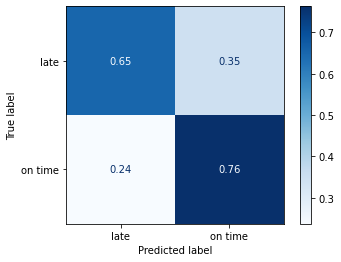

In [15]:
plot_confusion_matrix(logreg, X_test, y_test, display_labels = ['late', 'on time'], normalize = 'true', cmap = 'Blues')
plt.savefig('cm.png', dpi = 300)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.69      0.65      0.67     45232
        True       0.73      0.76      0.74     54768

    accuracy                           0.71    100000
   macro avg       0.71      0.71      0.71    100000
weighted avg       0.71      0.71      0.71    100000



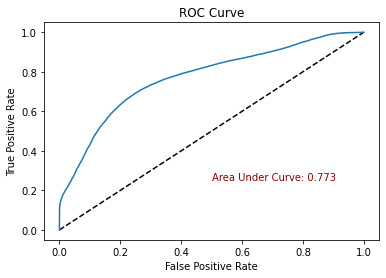

In [18]:
#copute predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

#get roc-auc
roc_auc = roc_auc_score(y_test, y_pred_prob)

#create annotation for plot
annot = 'Area Under Curve: {:.3f}'.format(roc_auc)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.annotate(annot, (0.5, 0.25), c = "DarkRed")
plt.show()